In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures

# Models:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import root_mean_squared_error, accuracy_score, mean_squared_error

# Kunskapskontroll

### Fyll i uppgifterna nedan innan du lämnar in på LearnPoint: 
Namn på samtliga gruppmedlemmar: 

# Project Steps

* Import & Analyze the Data
* Analyze features & measue feature importance
* Clean up data missing values
* Transform Data
* Build pipeline (-> Transform data, Scale Data )
* GridSearch parametergrid for models
* Validate model
* Test model

# Code

#### Loading Data

In [2]:
original_data = pd.read_csv(r'.\kunskapskontroll_ai2_del1\housing.csv')

#### EDA of Original Data

In [3]:
original_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
original_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


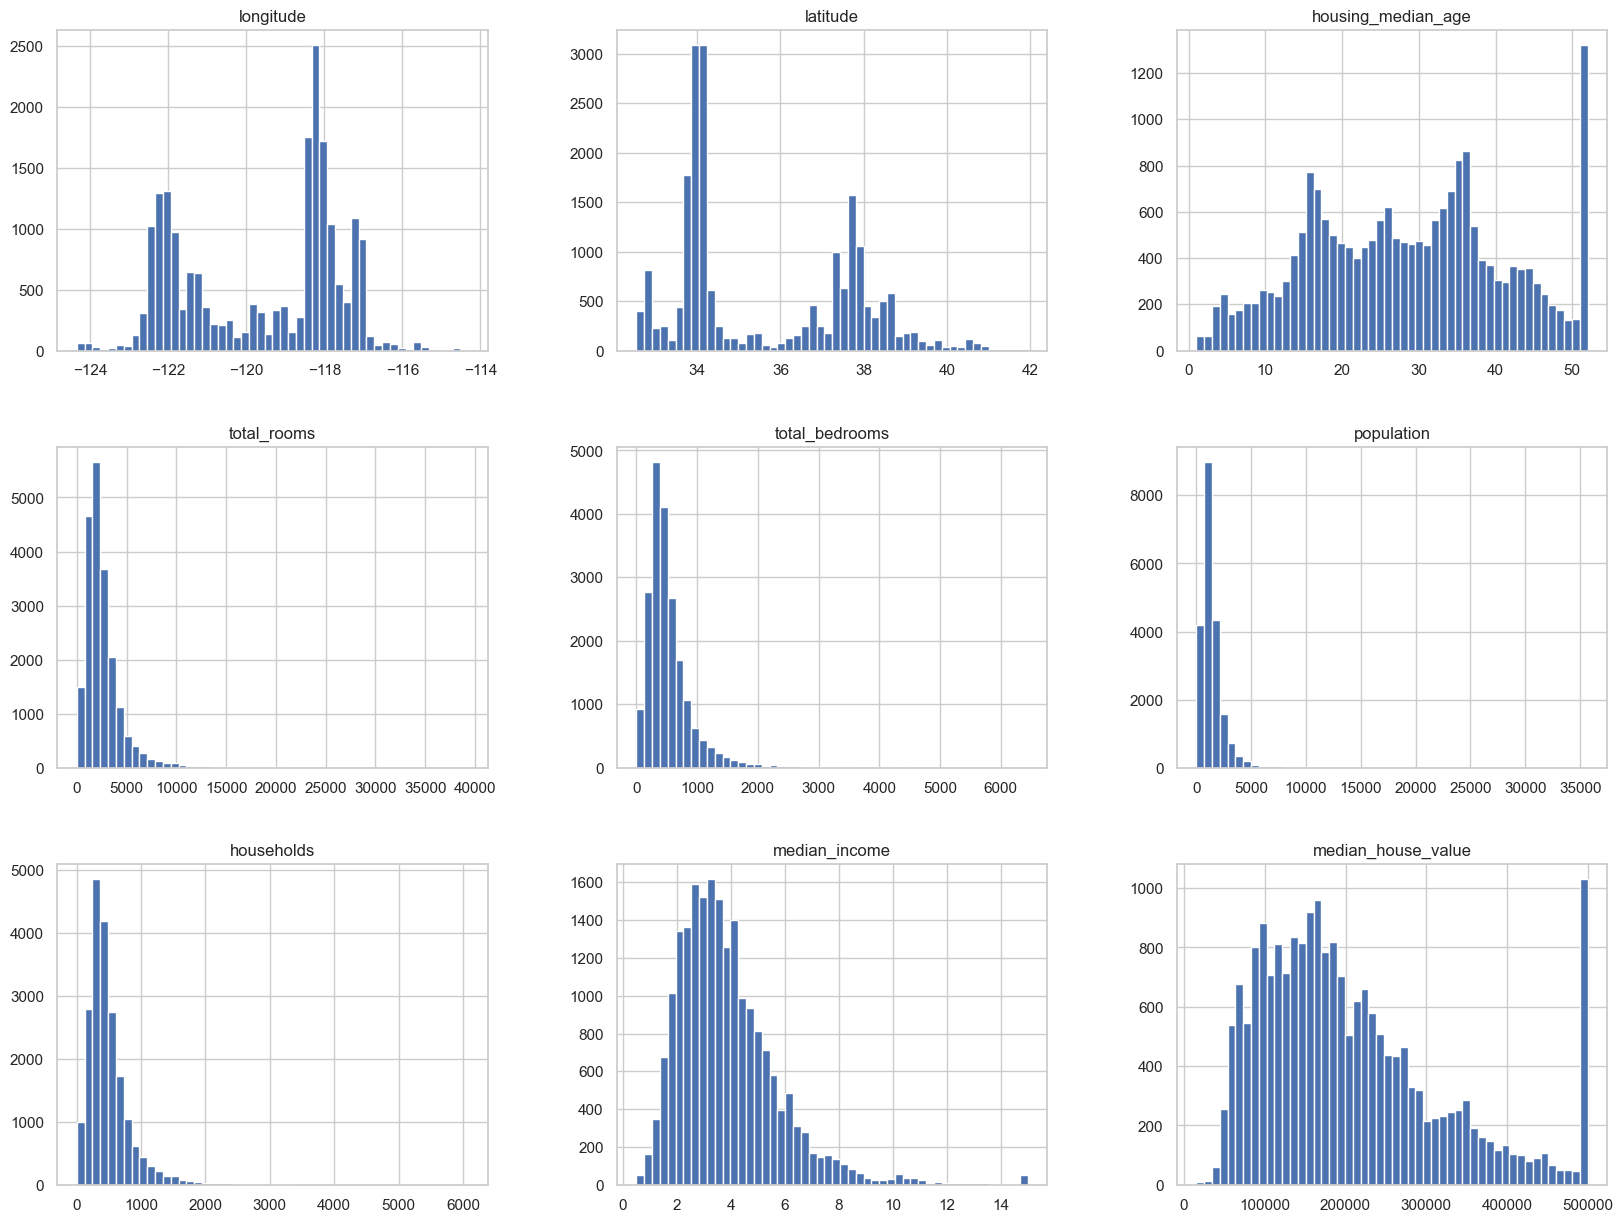

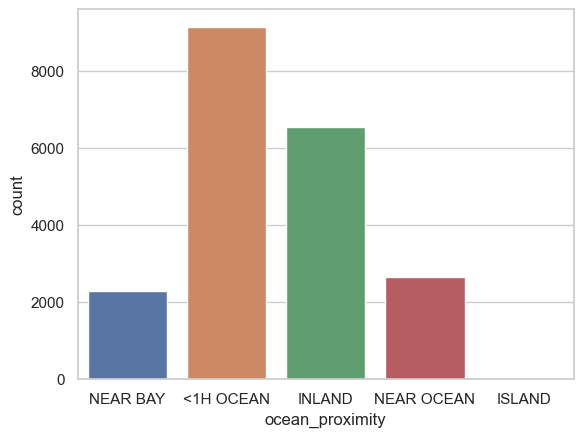

In [5]:
sns.set(style="whitegrid")

# Histograms of Original Data (count)
original_data.hist(bins=50, figsize=(20, 15))
plt.show()

# Bar plot for Ocean Proximity
sns.countplot(x='ocean_proximity', data=original_data)
plt.show()

In [6]:
# drop island
print("Original Data: Ocean Proximity Count")
print(original_data.ocean_proximity.value_counts())
print("Total: ",original_data.ocean_proximity.count())

Original Data: Ocean Proximity Count
ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64
Total:  20640


### Feature Engineering & Feature Selection

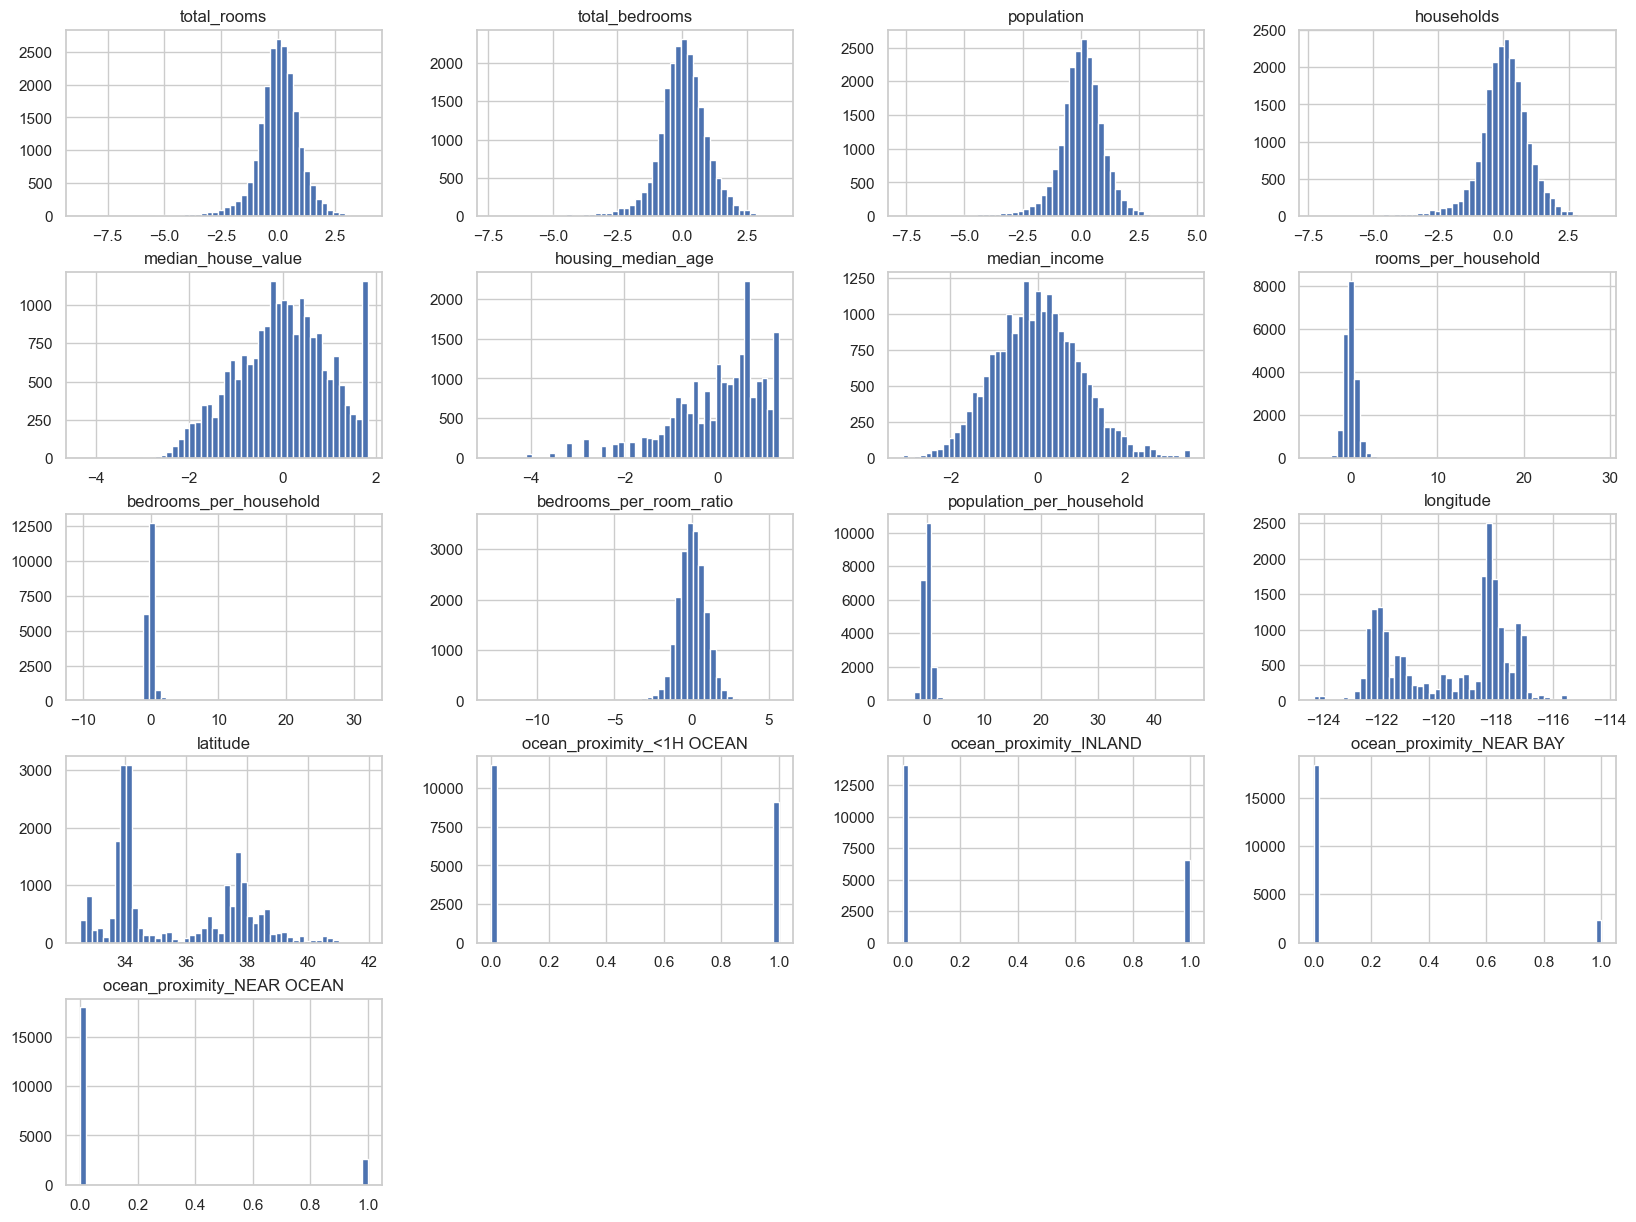

In [7]:
data = original_data

# Remove 'ISLAND' category from 'ocean_proximity' since it only has 5 cases.
data = data[data['ocean_proximity'] != 'ISLAND'].copy()

# Apply log transformation to relevant features
data.loc[:, 'total_rooms'] = np.log(data['total_rooms'] + 1)
data.loc[:, 'total_bedrooms'] = np.log(data['total_bedrooms'] + 1)
data.loc[:, 'population'] = np.log(data['population'] + 1)
data.loc[:, 'households'] = np.log(data['households'] + 1)

# Apply log transformation to features with spikes
data.loc[:, 'median_house_value'] = np.log(data['median_house_value'] + 1)
data.loc[:, 'housing_median_age'] = np.log(data['housing_median_age'] + 1)
data.loc[:, 'median_income'] = np.log(data['median_income'] + 1)

# Creating new feature columns in the Dataset
data.loc[:, 'rooms_per_household'] = data['total_rooms'] / data['households']
data.loc[:, 'bedrooms_per_household'] = data['total_bedrooms'] / data['households']
data.loc[:, 'bedrooms_per_room_ratio'] = data['total_bedrooms'] / data['total_rooms']
data.loc[:, 'population_per_household'] = data['population'] / data['households']

# Transforming 'ocean_proximity' feature using dummy variable encoding
data = pd.get_dummies(data, columns=['ocean_proximity'], dtype=int)

numerical_features = [
    'total_rooms', 'total_bedrooms', 'population', 'households',
    'median_house_value', 'housing_median_age', 'median_income',
    'rooms_per_household', 'bedrooms_per_household',
    'bedrooms_per_room_ratio', 'population_per_household'
]

# Exclude numerical features in "encoded categorical features"
encoded_categorical_features = [col for col in data.columns if col not in numerical_features]

# Apply StandardScaler to the numerical features
scaler = StandardScaler()
data_scaled_numerical = pd.DataFrame(scaler.fit_transform(data[numerical_features]), columns=numerical_features)

# Combine scaled numerical features with one-hot encoded features
data_scaled = pd.concat([data_scaled_numerical, data[encoded_categorical_features].reset_index(drop=True)], axis=1)

data_scaled.hist(bins=50, figsize=(20, 15))
plt.show()


In [8]:
# Inspecting the scaled data
data_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20635 entries, 0 to 20634
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   total_rooms                 20635 non-null  float64
 1   total_bedrooms              20428 non-null  float64
 2   population                  20635 non-null  float64
 3   households                  20635 non-null  float64
 4   median_house_value          20635 non-null  float64
 5   housing_median_age          20635 non-null  float64
 6   median_income               20635 non-null  float64
 7   rooms_per_household         20635 non-null  float64
 8   bedrooms_per_household      20428 non-null  float64
 9   bedrooms_per_room_ratio     20428 non-null  float64
 10  population_per_household    20635 non-null  float64
 11  longitude                   20635 non-null  float64
 12  latitude                    20635 non-null  float64
 13  ocean_proximity_<1H OCEAN   206

In [9]:
# List of features used for the training data:
housing_features = [
    'median_house_value',
    'longitude',
    'latitude',
    'housing_median_age',
    'median_income',
    'rooms_per_household',
    'bedrooms_per_room_ratio',
    'population_per_household',
    'ocean_proximity_<1H OCEAN',
    'ocean_proximity_INLAND', 
    'ocean_proximity_NEAR BAY', 
    'ocean_proximity_NEAR OCEAN',
]
housing = data_scaled[housing_features]

## EDA on Transformed Data

#### Inspecting Transformed Data

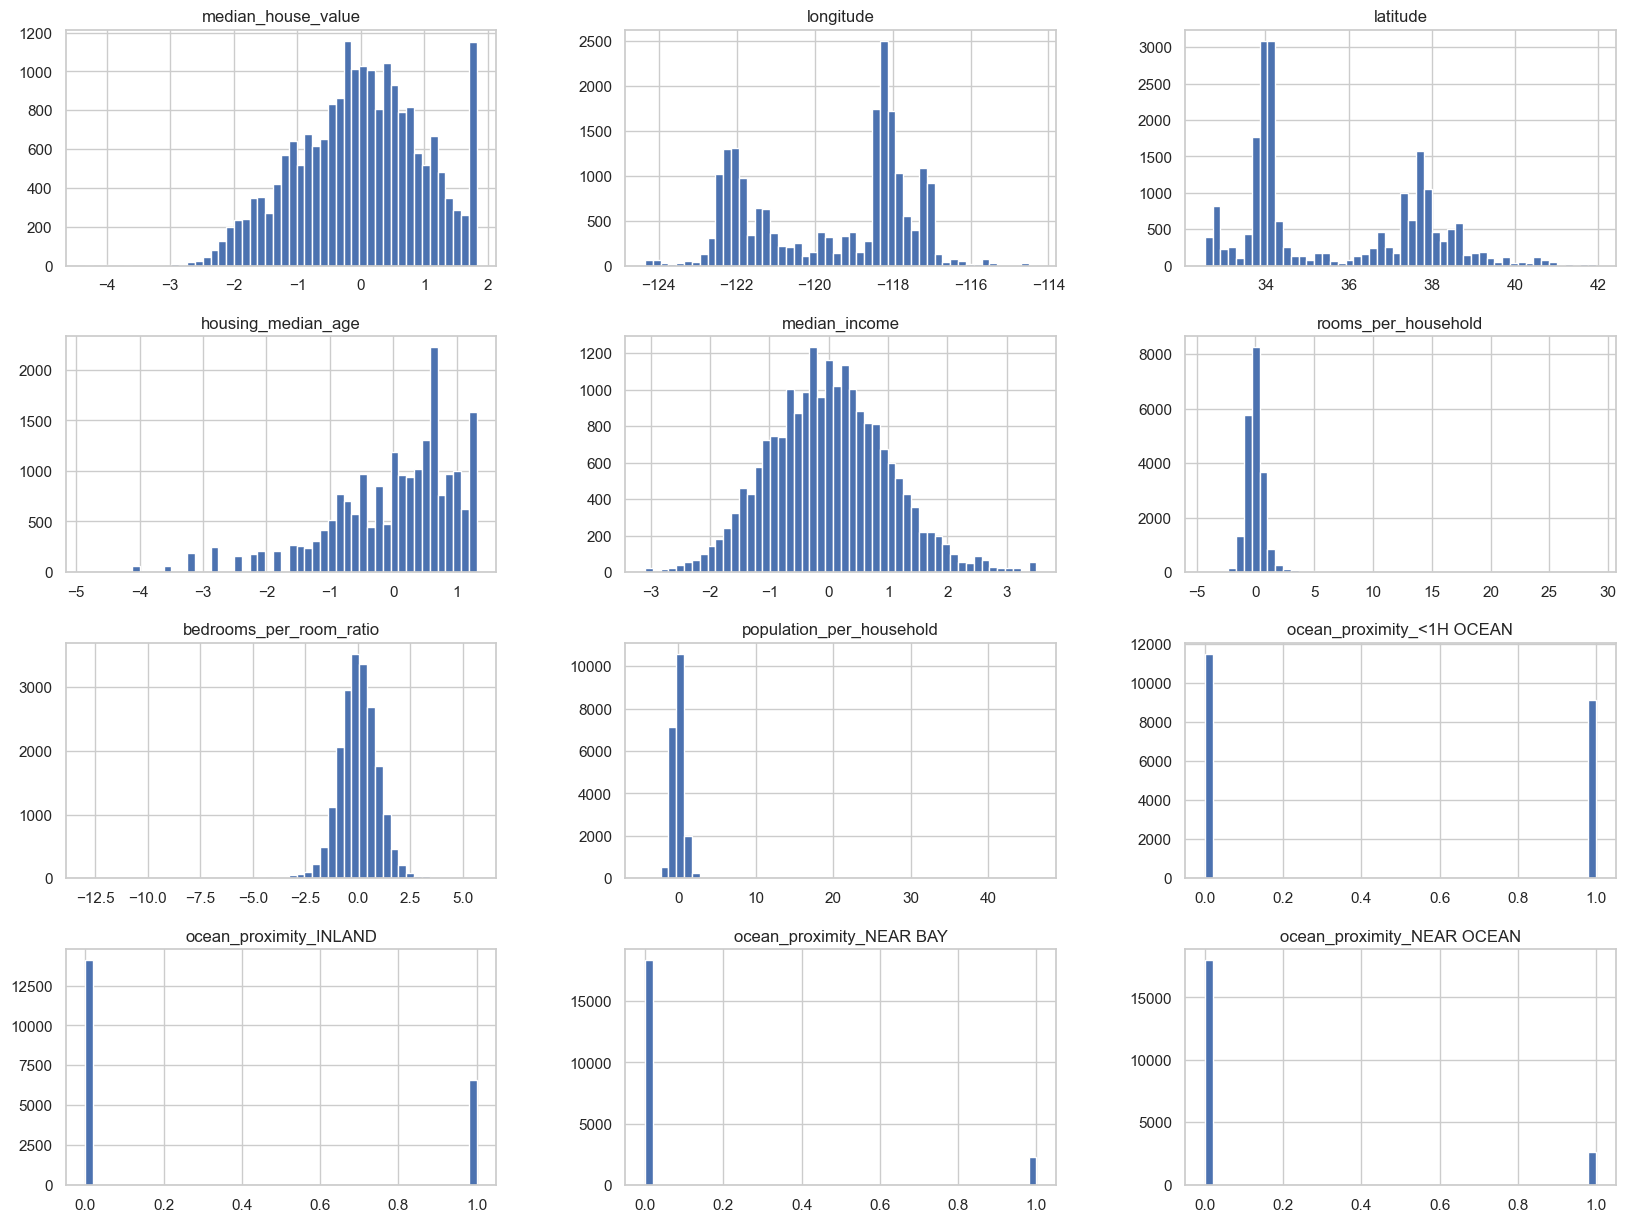

In [10]:
housing.hist(bins=50, figsize=(20, 15))
plt.show()

#### Checking Missing Values

In [11]:
housing.info()

print('-'*50)

# Checking for missing Values
housing.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20635 entries, 0 to 20634
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   median_house_value          20635 non-null  float64
 1   longitude                   20635 non-null  float64
 2   latitude                    20635 non-null  float64
 3   housing_median_age          20635 non-null  float64
 4   median_income               20635 non-null  float64
 5   rooms_per_household         20635 non-null  float64
 6   bedrooms_per_room_ratio     20428 non-null  float64
 7   population_per_household    20635 non-null  float64
 8   ocean_proximity_<1H OCEAN   20635 non-null  int32  
 9   ocean_proximity_INLAND      20635 non-null  int32  
 10  ocean_proximity_NEAR BAY    20635 non-null  int32  
 11  ocean_proximity_NEAR OCEAN  20635 non-null  int32  
dtypes: float64(8), int32(4)
memory usage: 1.6 MB
-------------------------------------------

median_house_value              0
longitude                       0
latitude                        0
housing_median_age              0
median_income                   0
rooms_per_household             0
bedrooms_per_room_ratio       207
population_per_household        0
ocean_proximity_<1H OCEAN       0
ocean_proximity_INLAND          0
ocean_proximity_NEAR BAY        0
ocean_proximity_NEAR OCEAN      0
dtype: int64

## TODO: Handle Missing Values

In [12]:
# Drop all null values
## Use Imputer instead
# housing.fillna(housing.median(), inplace=True)
housing.dropna(inplace=True)

housing.info()
print('-'*50)
print('Null values:')
print(housing.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 20428 entries, 0 to 20634
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   median_house_value          20428 non-null  float64
 1   longitude                   20428 non-null  float64
 2   latitude                    20428 non-null  float64
 3   housing_median_age          20428 non-null  float64
 4   median_income               20428 non-null  float64
 5   rooms_per_household         20428 non-null  float64
 6   bedrooms_per_room_ratio     20428 non-null  float64
 7   population_per_household    20428 non-null  float64
 8   ocean_proximity_<1H OCEAN   20428 non-null  int32  
 9   ocean_proximity_INLAND      20428 non-null  int32  
 10  ocean_proximity_NEAR BAY    20428 non-null  int32  
 11  ocean_proximity_NEAR OCEAN  20428 non-null  int32  
dtypes: float64(8), int32(4)
memory usage: 1.7 MB
------------------------------------------------

C:\Users\Holt\AppData\Local\Temp\ipykernel_24464\1452058427.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing.dropna(inplace=True)


### Correlation Matrix

In [13]:
# Visualising Housing dataset Correlation
correlation_matrix = housing.corr()
target_correlations = correlation_matrix['median_house_value'].sort_values(ascending=False)
sns.set(style="whitegrid")

target_correlations

median_house_value            1.000000
median_income                 0.681999
ocean_proximity_<1H OCEAN     0.332814
ocean_proximity_NEAR BAY      0.161966
ocean_proximity_NEAR OCEAN    0.143542
rooms_per_household           0.071139
housing_median_age            0.050754
longitude                    -0.023057
bedrooms_per_room_ratio      -0.165745
population_per_household     -0.181751
latitude                     -0.192498
ocean_proximity_INLAND       -0.567439
Name: median_house_value, dtype: float64

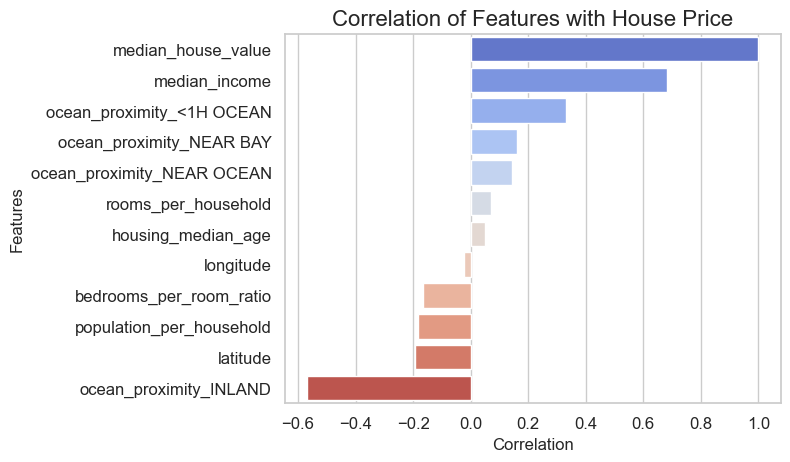

In [14]:
# Correlation Barplot
bar_plot = sns.barplot(x=target_correlations.values, y=target_correlations.index, palette="coolwarm")
plt.title("Correlation of Features with House Price")
bar_plot.set_title("Correlation of Features with House Price", fontsize=16)
bar_plot.set_xlabel("Correlation")
bar_plot.set_ylabel("Features")
bar_plot.tick_params(labelsize=12)
plt.show()

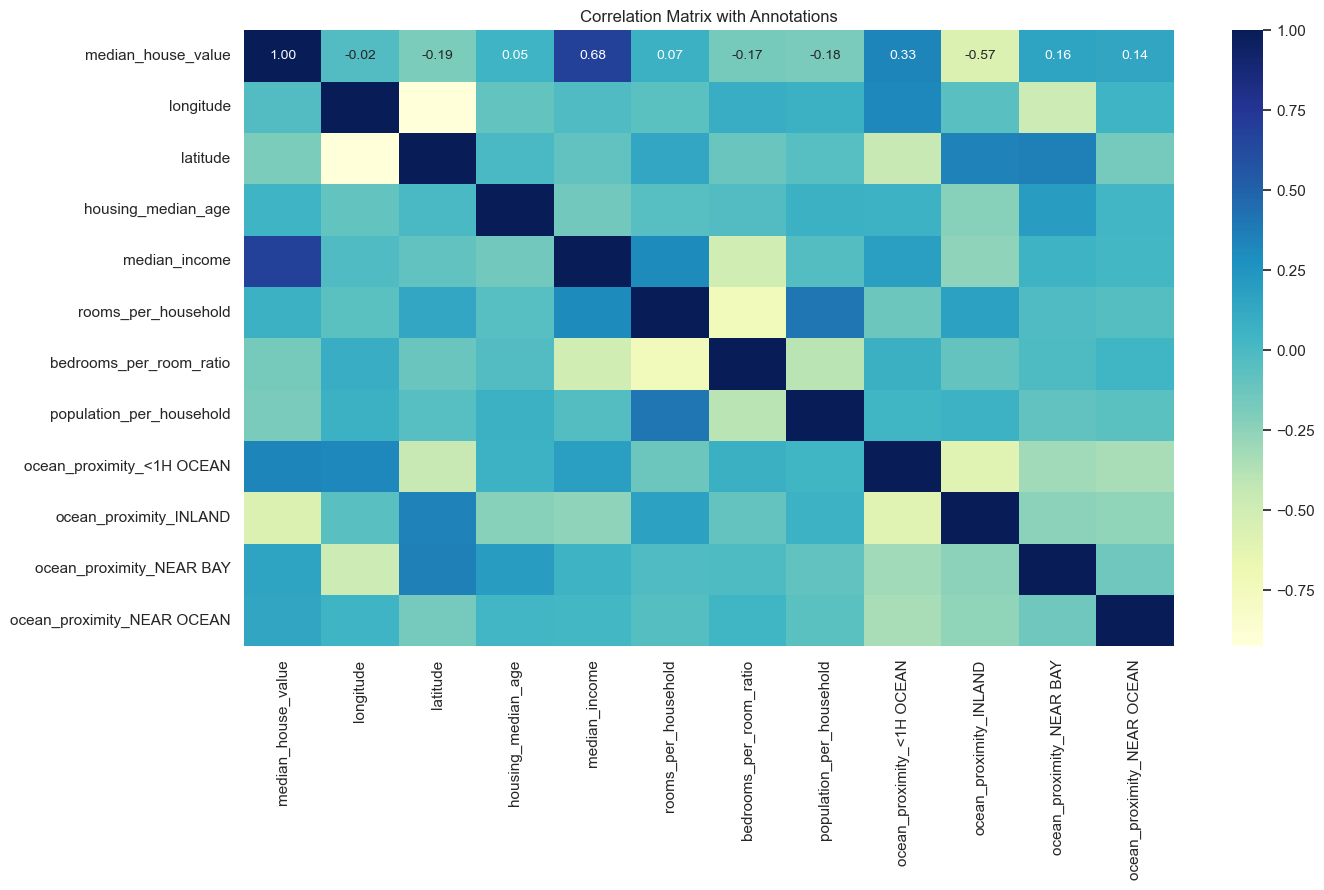

In [15]:
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', annot_kws={"size": 10}, fmt=".2f")
plt.title('Correlation Matrix with Annotations')
plt.show()

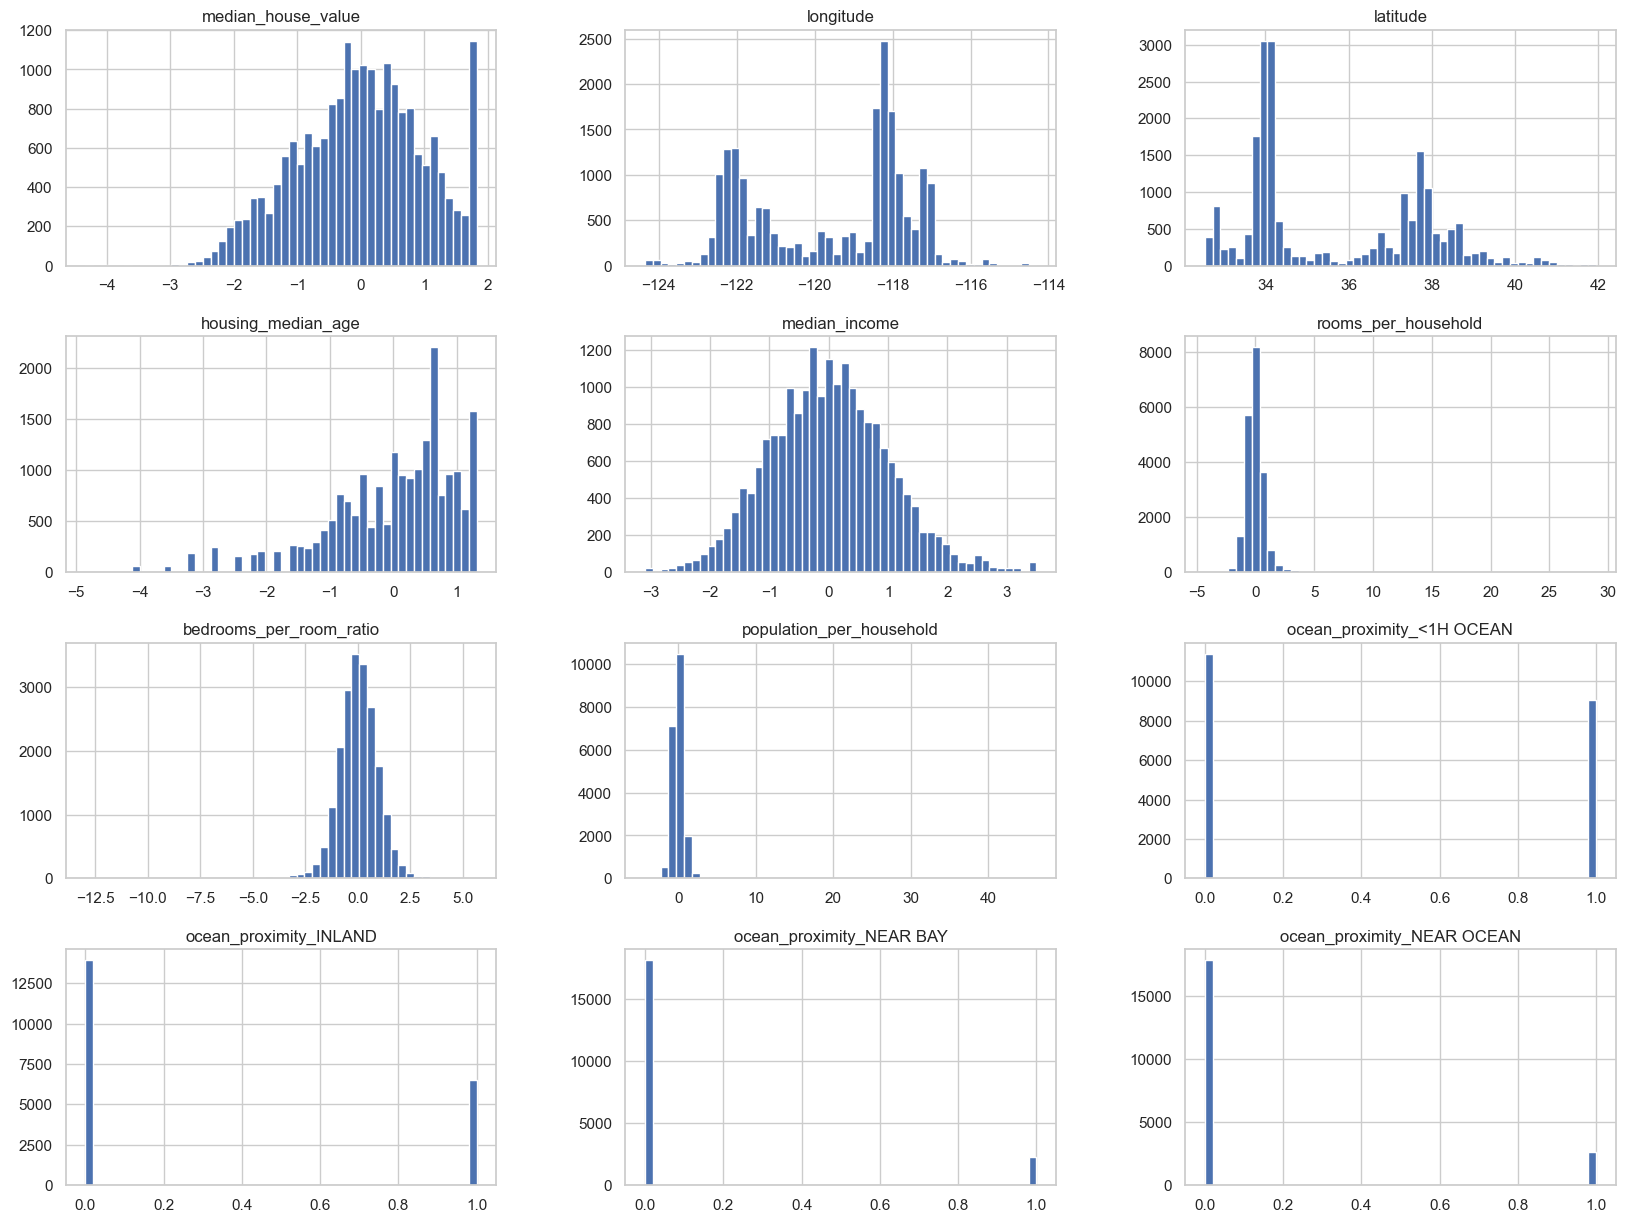

In [16]:
# Histograms
housing.hist(bins=50, figsize=(20, 15))
plt.show()

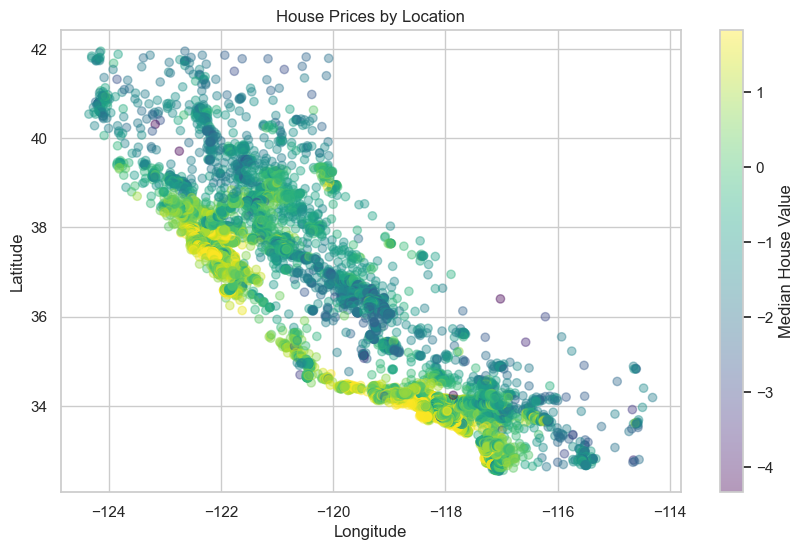

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(housing['longitude'], housing['latitude'], alpha=0.4, c=housing['median_house_value'], cmap='viridis')
plt.colorbar(label='Median House Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('House Prices by Location')
plt.show()

# Map of California

### Inspecting house median age & house median value capped values

In [18]:
max_values = housing.max()

capped_values = {
    'housing_median_age': max_values['housing_median_age'],
    'median_house_value': max_values['median_house_value'],
    'median_income': max_values['median_income'],
    'population_per_household': max_values['population_per_household'],
    'rooms_per_household': max_values['rooms_per_household'],
    'bedrooms_per_room_ratio': max_values['bedrooms_per_room_ratio']
}

print(max_values)

median_house_value              1.823461
longitude                    -114.310000
latitude                       41.950000
housing_median_age              1.314893
median_income                   3.500335
rooms_per_household            28.970501
bedrooms_per_room_ratio         5.662424
population_per_household       46.227314
ocean_proximity_<1H OCEAN       1.000000
ocean_proximity_INLAND          1.000000
ocean_proximity_NEAR BAY        1.000000
ocean_proximity_NEAR OCEAN      1.000000
dtype: float64


In [19]:
capped_house_value = data_scaled[data_scaled['median_house_value'] == capped_values['median_house_value']]
capped_age = data_scaled[data_scaled['housing_median_age'] == capped_values['housing_median_age']]
capped_income = data_scaled[data_scaled['median_income'] == capped_values['median_income']]
capped_population = data_scaled[data_scaled['population_per_household'] == capped_values['population_per_household']]
capped_rooms = data_scaled[data_scaled['rooms_per_household'] == capped_values['rooms_per_household']]
# capped_bedrooms = data_scaled[data_scaled['bedrooms_per_household'] == capped_values['bedrooms_per_household']]
capped_ratio = data_scaled[data_scaled['bedrooms_per_room_ratio'] == capped_values['bedrooms_per_room_ratio']]

print("Capped House Value Cases:\n", capped_house_value.count())
print("\nCapped Age Cases:\n", capped_age.count())
print("\nCapped Income Cases:\n", capped_income.count())
print("\nCapped Population Cases:\n", capped_population.count())
print("\nCapped Rooms Cases:\n", capped_rooms.count())
# print("\nCapped Bedrooms Cases:\n", capped_bedrooms.count())
print("\nCapped Ratio Cases:\n", capped_ratio.count())

Capped House Value Cases:
 total_rooms                   965
total_bedrooms                958
population                    965
households                    965
median_house_value            965
housing_median_age            965
median_income                 965
rooms_per_household           965
bedrooms_per_household        958
bedrooms_per_room_ratio       958
population_per_household      965
longitude                     965
latitude                      965
ocean_proximity_<1H OCEAN     965
ocean_proximity_INLAND        965
ocean_proximity_NEAR BAY      965
ocean_proximity_NEAR OCEAN    965
dtype: int64

Capped Age Cases:
 total_rooms                   1270
total_bedrooms                1262
population                    1270
households                    1270
median_house_value            1270
housing_median_age            1270
median_income                 1270
rooms_per_household           1270
bedrooms_per_household        1262
bedrooms_per_room_ratio       1262
population_p

## Data Cleanup

## Model

In [20]:
# Defining Median House Value as target variable.
X = housing.drop('median_house_value', axis=1)
y = housing['median_house_value']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42)

In [21]:
# Lin Reg
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_val)

rmse = root_mean_squared_error(y_val, y_pred)

print('rmse', rmse)
lin_reg.score(X_val, y_val)

rmse 0.5634546503746314


0.6796134412320832

In [22]:
# Random Forest Regressor
rf_reg = RandomForestRegressor(random_state=42)

rf_reg.fit(X_train, y_train)
y_pred = rf_reg.predict(X_val)


rmse = root_mean_squared_error(y_val, y_pred)
print('rmse', rmse)
rf_reg.score(X_val, y_val)


rmse 0.4160132538056453


0.825349156811956

In [23]:
# Decision Tree Regressor
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train, y_train)
y_pred = dt_reg.predict(X_val)

rmse = root_mean_squared_error(y_val, y_pred)

print('rmse', rmse)
dt_reg.score(X_val, y_val)


rmse 0.5764017531538568


0.6647205474690585

In [24]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
y_pred = svr.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"SVR RMSE: {rmse}")
svr.score(X_val, y_val)

SVR RMSE: 0.6206088859468935


0.6113198768383057

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Gradient Boosting RMSE: {rmse}")
gbr.score(X_val, y_val)

Gradient Boosting RMSE: 0.4435616296621739


0.8014525592792707

In [26]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train, y_train)
y_pred = knn_reg.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"KNN RMSE: {rmse}")
knn_reg.score(X_val, y_val)

KNN RMSE: 0.4522896113210271


0.7935620310643858

In [27]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(random_state=42)
elastic_net.fit(X_train, y_train)
y_pred = elastic_net.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"ElasticNet RMSE: {rmse}")
elastic_net.score(X_val, y_val)

ElasticNet RMSE: 0.9177531927951924


0.15002106909646806